In [41]:
import pandas as pd
import glob
import os

# Carpeta con los CSV
path = "Datos/Originales/*.csv"
files = glob.glob(path)

dfs = []

for f in files:
    # Nombre del dataset sin extensión (ej: "AAPL")
    name = os.path.splitext(os.path.basename(f))[0]

    # Leer CSV
    temp = pd.read_csv(f, index_col='date')  # asumimos que la primera columna es fecha o índice
    temp.index = pd.to_datetime(temp.index)  # asegurar índice tipo fecha
    temp = temp[~temp.index.duplicated()]    # eliminar posibles duplicados

    # Crear MultiIndex en columnas: (columna original, nombre dataset)
    temp.columns = pd.MultiIndex.from_product([temp.columns, [name]])

    dfs.append(temp)

# Concatenar todos los DataFrames por columnas
df = pd.concat(dfs, axis=1)
df = df.close
df.columns = df.columns.str.replace("_marketstack", "", regex=False)

<Axes: xlabel='date'>

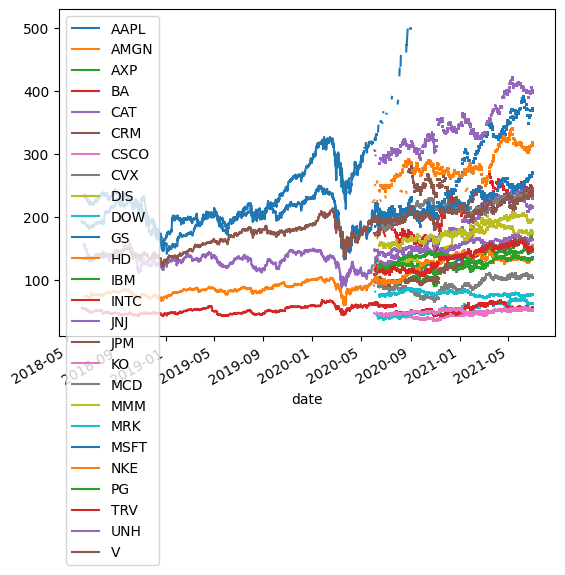

In [42]:
df.plot()

In [43]:
# 1. Crear nueva columna auxiliar solo con la fecha (sin hora)
df['date_only'] = df.index.date

# 2. Agrupar por esa fecha y seleccionar el último registro de cada día
df = df.groupby('date_only').last()

# 3. (Opcional) Reindexar para usar esa nueva columna como índice datetime solo con la fecha
df.index = pd.to_datetime(df.index)
df.index.name = 'date'
df.index = df.index.date

In [44]:
df.head()

,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,DOW,...,KO,MCD,MMM,MRK,MSFT,NKE,PG,TRV,UNH,V
2018-06-06,194.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-06-07,193.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-06-08,191.51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-06-09,191.51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-06-11,191.16,NaN,NaN,NaN,156.35,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,133.88


In [45]:
df.shape

(954, 26)

In [46]:
# Máscara para filas cuyo índice (fecha) es sábado (5) o domingo (6)
mask_weekend = pd.to_datetime(df.index).weekday >= 5

# Filtrar: eliminar solo filas que tienen NA y son fines de semana
df = df[~(mask_weekend)]

In [47]:
df.isna().sum()

AAPL      6
AMGN    524
AXP     524
BA      524
CAT       9
CRM     524
CSCO    524
CVX     524
DIS     524
DOW     526
GS        9
HD      526
IBM     526
INTC      7
JNJ     524
JPM     524
KO      524
MCD     524
MMM     527
MRK     527
MSFT    527
NKE      10
PG      526
TRV     527
UNH     527
V         8
dtype: int64

In [48]:
import yfinance as yf
import pandas as pd

nombres = df.columns.tolist()
datos = {}

for nombre in nombres:
    ticker_obj = yf.Ticker(nombre)
    historial = ticker_obj.history(start='2018-06-06', end='2021-07-02')
    # Solo tomar la columna 'Close'
    datos[nombre] = historial['Close']

# Crear un DataFrame con las series temporales de cierre por empresa
df_finance = pd.DataFrame(datos)
df_finance.index = df_finance.index.date

In [49]:
df_final = df.fillna(df_finance)

In [50]:
df_final.isna().sum()

AAPL      1
AMGN     20
AXP      20
BA       20
CAT       1
CRM      20
CSCO     20
CVX      20
DIS      20
DOW     217
GS        1
HD       20
IBM      20
INTC      1
JNJ      20
JPM      20
KO       20
MCD      20
MMM      20
MRK      20
MSFT     20
NKE       1
PG       20
TRV      19
UNH      19
V         0
dtype: int64

In [51]:
df_final

,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,DOW,...,KO,MCD,MMM,MRK,MSFT,NKE,PG,TRV,UNH,V
2018-06-06,194.000000,147.111725,91.481720,357.617035,133.062454,134.138992,35.603947,89.986603,97.482872,NaN,...,34.410648,137.123871,131.013824,46.958897,95.293930,68.293900,61.601471,109.253754,220.979401,129.619110
2018-06-07,193.500000,146.911407,91.943810,354.700775,132.875397,131.526459,35.113243,92.597679,98.018539,NaN,...,34.394802,143.119553,131.791443,47.004398,93.796982,68.303055,62.769718,110.764526,221.272644,127.298363
2018-06-08,191.510000,147.712845,91.508896,355.634399,132.050720,132.139984,34.976486,92.218414,99.462944,NaN,...,34.798622,142.638245,132.768219,47.451775,94.494331,68.430946,63.946243,112.087517,222.783463,128.154373
2018-06-11,191.160000,147.961319,91.690109,357.020325,156.350000,132.585312,35.145424,93.035278,99.816887,NaN,...,34.941128,140.594620,131.823563,47.262211,93.955055,68.147713,64.236221,111.387619,225.538498,133.880000
2018-06-12,192.320000,148.329987,91.264275,356.712311,157.485000,134.841568,35.346539,92.685188,99.797737,NaN,...,35.162830,140.797256,131.695007,47.345615,94.196800,74.300000,63.995953,110.602364,225.360733,134.880000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-25,133.410000,240.950000,168.210000,250.570000,219.340000,243.770000,52.780000,107.140000,177.930000,63.110000,...,54.390000,233.330000,193.260000,76.360000,266.690000,133.600000,133.020000,149.970000,398.870000,236.240000
2021-06-28,133.110000,242.680000,169.450000,248.380000,216.310000,241.870000,53.060000,107.300000,178.350000,63.290000,...,54.320000,232.420000,194.750000,77.200000,265.020000,154.350000,134.920000,151.720000,404.950000,237.320000
2021-06-29,134.780000,242.840000,164.780000,239.960000,216.270000,244.570000,52.960000,103.990000,176.570000,62.900000,...,54.260000,231.090000,196.500000,76.860000,268.720000,152.360000,135.320000,149.450000,401.460000,234.090000
2021-06-30,136.330000,242.460000,164.250000,235.760000,215.100000,245.810000,52.910000,103.760000,173.930000,62.980000,...,53.860000,230.370000,196.030000,77.210000,271.400000,155.950000,134.400000,149.520000,398.100000,235.950000


In [52]:
fecha_inicio = pd.to_datetime(df_final.index.min())
fecha_fin = pd.to_datetime(df_final.index.max())
splits_dict = {}
for symbol in df_final.columns:
    ticker = yf.Ticker(symbol)
    splits = ticker.splits
    if not splits.empty and not isinstance(splits.index, pd.DatetimeIndex):
        splits.index = pd.to_datetime(splits.index)
    if not splits.empty and splits.index.tz is not None:
        splits.index = splits.index.tz_convert(None)
    splits_filtrados = splits[(splits.index >= fecha_inicio) & (splits.index <= fecha_fin)] if not splits.empty else splits
    if not splits_filtrados.empty:
        splits_dict[symbol] = splits_filtrados
if splits_dict:
    print("Splits detectados:")
    for symbol, splits in splits_dict.items():
        print(f"{symbol}:\n{splits}")
else:
    print("Ningúno tienen algun splits.")
df_finalisimo = df_final.copy()
for symbol in splits_dict.keys():
    splits = splits_dict[symbol]
    for fecha_split, factor in splits.items():
        if isinstance(fecha_split, pd.Timestamp):
            fecha_split_ts = fecha_split
        else:
            fecha_split_ts = pd.Timestamp(fecha_split)
        idx_ts = pd.to_datetime(df_finalisimo.index)
        mask = idx_ts < fecha_split_ts
        df_finalisimo.loc[mask, symbol] = df_finalisimo.loc[mask, symbol] / factor
df_finalisimo.head()

Splits detectados:
AAPL:
Date
2020-08-31 04:00:00    4.0
Name: Stock Splits, dtype: float64
MRK:
Date
2021-06-03 04:00:00    1.048
Name: Stock Splits, dtype: float64


,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,DOW,...,KO,MCD,MMM,MRK,MSFT,NKE,PG,TRV,UNH,V
2018-06-06,48.5000,147.111725,91.481720,357.617035,133.062454,134.138992,35.603947,89.986603,97.482872,NaN,...,34.410648,137.123871,131.013824,44.808107,95.293930,68.293900,61.601471,109.253754,220.979401,129.619110
2018-06-07,48.3750,146.911407,91.943810,354.700775,132.875397,131.526459,35.113243,92.597679,98.018539,NaN,...,34.394802,143.119553,131.791443,44.851525,93.796982,68.303055,62.769718,110.764526,221.272644,127.298363
2018-06-08,47.8775,147.712845,91.508896,355.634399,132.050720,132.139984,34.976486,92.218414,99.462944,NaN,...,34.798622,142.638245,132.768219,45.278411,94.494331,68.430946,63.946243,112.087517,222.783463,128.154373
2018-06-11,47.7900,147.961319,91.690109,357.020325,156.350000,132.585312,35.145424,93.035278,99.816887,NaN,...,34.941128,140.594620,131.823563,45.097529,93.955055,68.147713,64.236221,111.387619,225.538498,133.880000
2018-06-12,48.0800,148.329987,91.264275,356.712311,157.485000,134.841568,35.346539,92.685188,99.797737,NaN,...,35.162830,140.797256,131.695007,45.177114,94.196800,74.300000,63.995953,110.602364,225.360733,134.880000


In [53]:
df_final = df_finalisimo.drop('DOW', axis=1)

In [54]:
df_final = df_final.interpolate(method='linear', axis=0)

In [55]:
df_final.isna().sum()

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     0
GS      0
HD      0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
dtype: int64